In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import classification_report
from tqdm import tqdm
import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.samplers import TPESampler

from util import make_overheat, make_adjust, help

In [41]:
help()


        두 함수 모두 noise 데이터셋을 기준으로 합니다.
        단 noise 데이터셋 형태로 계약년월, 시군구, 시 특성이 있다면 어떤 데이터에도 적용할 수 있습니다
        ---------------------------------
        make_overheat
        1. 투기과열지구 특성을 추가합니다
        2. '계약년월', '시' 특성이 필수적으로 요구됩니다

        make_adjust
        1. 조정대상지역 특성을 추가합니다
        2.  '계약년월', '시', '시군구' 특성을 필수적으로 요구합니다 
        ---------------------------------
        
        공통 주의사항
        1. 두 함수 모두 말미에 모든 행의 결측치를 0으로 대체합니다. 필요에 따라 말미의 fillna함수를 수정하시기 바랍니다
        2. 계약년월의 기간은 201908~202307입니다, 기간이 다른 경우 문제가 발생할 수 있습니다. 코드 까보면 이해할 수 있지만 도움이 필요하면 바로 말씀해주세요.
        


In [43]:
df = pd.read_csv('data/region_inter.csv')

In [44]:
# 특성 추가 및 특성 공학
df = make_overheat(df)
df = make_adjust(df)

In [45]:
# EDA를 위해 전세가율, 계약년도, 광역 특성 만들기
df['전세가율'] = df.면적당보증금 / df.면적당매매금
df['계약년도'] = df['계약년월'] // 100

# 광역행 만들기
df['광역'] = df['시'].str.split().str[0]

# 줄이기 위한 광역 키
REGIONKEY = {'강원특별자치도': '강원', '경기도': '경기', '경상남도': '경남',
            '경상북도': '경북', '광주광역시': '광주', '대구광역시': '대구', '대전광역시':'대전',
            '부산광역시': '부산', '서울특별시': '서울', '세종특별자치시': '세종', '울산광역시':'울산',
            '인천광역시': '인천', '전라남도':'전남', '전라북도':'전북', '제주특별자치도':'제주', '충청남도':'충남', '충청북도':'충북'}
df['광역'] = df['광역'].replace(REGIONKEY)

#### EDA

In [46]:
# 투기과열지구, 조정대상지역에 따른 매매가, 전세가, 전세가율
dataframe = [
    df.groupby(['투기과열지구'])[['면적당매매금', '면적당보증금', '전세가율']].mean(), 
    df.groupby(['조정대상지역'])[['면적당매매금', '면적당보증금', '전세가율']].mean()
]
pd.concat(dataframe, keys=['투기과열지구', '조정대상지역'], axis=1)

투기과열지구                            조정대상지역                      
        면적당매매금      면적당보증금      전세가율      면적당매매금      면적당보증금      전세가율
0   341.623367  246.866161  0.784830  313.932189  228.364758  0.792551
1  1146.714427  627.645328  0.594208  746.972052  447.646203  0.686902

투기과열지구, 조정대상지역에서 면적당매매금, 면적당보증금은 상승하지만 전세가율은 하락한다

In [47]:
# 계약년도에 따른 매매가, 전세가, 전세가율
dataframe = [
    df.groupby(['계약년도'])[['면적당보증금', '면적당매매금', '전세가율']].mean(),
    df.groupby(['계약년도'])[['면적당보증금', '면적당매매금', '전세가율']].std()
]
pd.concat(dataframe, keys=['평균', '표준편차'], axis=1)

평균                              표준편차                      
          면적당보증금      면적당매매금      전세가율      면적당보증금      면적당매매금      전세가율
계약년도                                                                    
2019  262.215377  388.340580  0.751875  172.469517  334.806792  0.214305
2020  286.508753  427.122643  0.756745  192.775461  376.273321  0.213812
2021  329.668518  517.114313  0.747522  212.907812  463.989756  0.237199
2022  336.558927  513.463932  0.766085  211.052841  449.371006  0.267042
2023  307.007823  485.503629  0.734955  188.575517  413.750790  0.255938

면적당보증금과 면적당매매금과 달리 계약년도에 따른 전세가율 평균은 큰 변동 없이 유지되는 경향이 있다

단, 표준편차를 확인하면 전세가율의 변동폭도 다른 특성처럼 증가하는 모습을 보였다

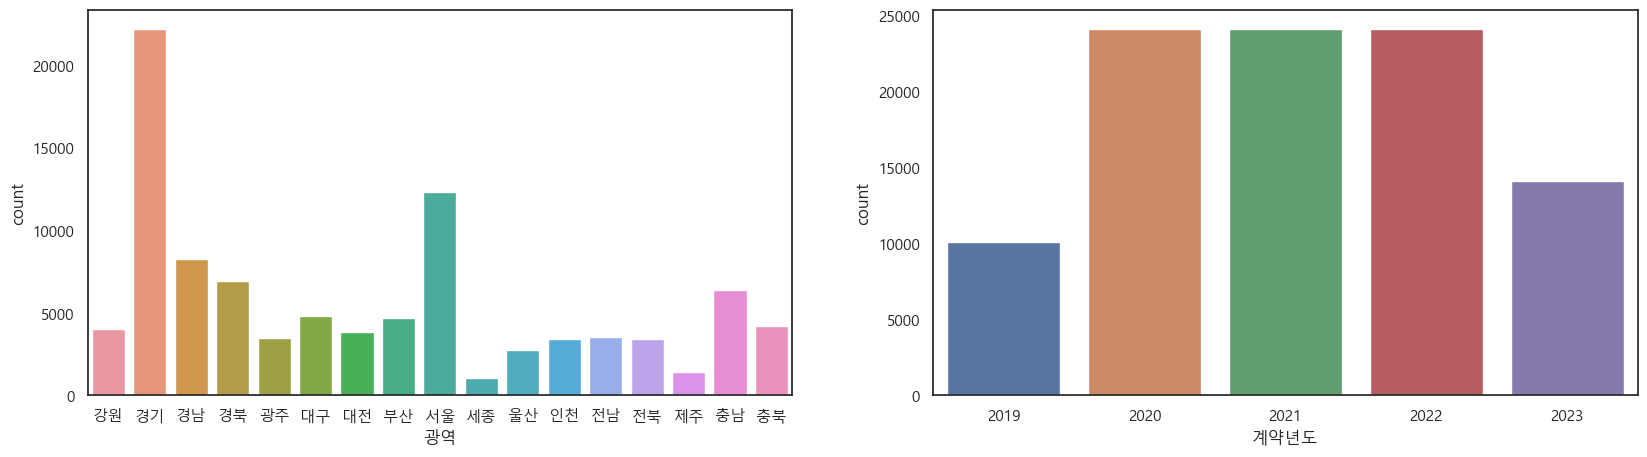

In [48]:
# 한글깨짐 방지
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

# 광역과 계약년도에 따른 빈도 확인
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
sns.countplot(x=df['광역'], ax=ax[0])
sns.countplot(x=df['계약년도'], ax=ax[1])
plt.show()

c:\Users\born9\anaconda3\envs\aptt\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


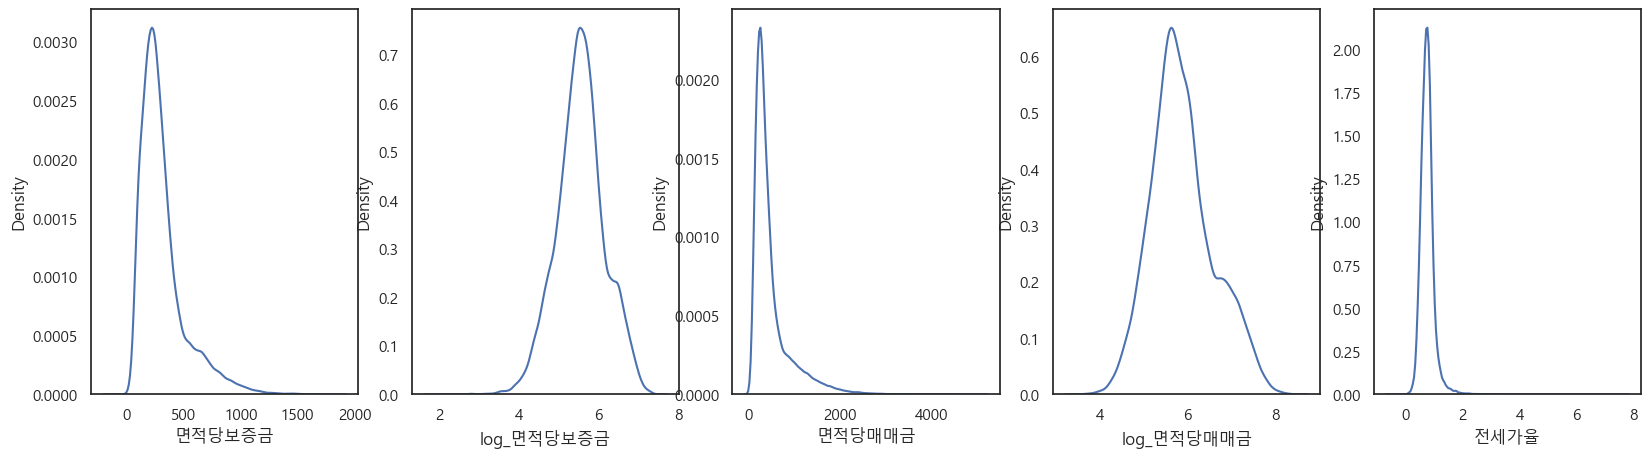

In [52]:
# 면적당보증금, 면적당매매금, 전세가율 분포 확인
fig, ax = fig, ax = plt.subplots(ncols=5, figsize=(20,5))
sns.kdeplot(x=df['면적당보증금'], ax=ax[0])
sns.kdeplot(x=df['면적당매매금'], ax=ax[2])
sns.kdeplot(x=df['전세가율'], ax=ax[4])

df['log_면적당매매금'] = np.log(df['면적당매매금'])
df['log_면적당보증금'] = np.log(df['면적당보증금'])

# 면적당보증금, 면적당매매금 log 변환
sns.kdeplot(x=df['log_면적당보증금'], ax=ax[1])
sns.kdeplot(x=df['log_면적당매매금'], ax=ax[3])
plt.show()

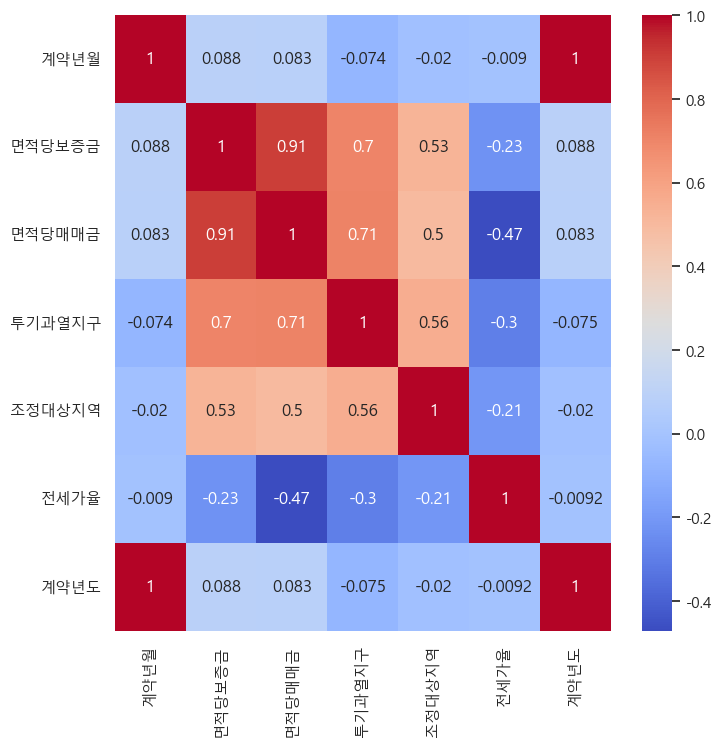

In [54]:
remove_target = ['log_면적당매매금', 'log_면적당보증금']
df_temp = df.drop(columns=remove_target)

# 상관계수 행렬 계산
correlation_matrix = df_temp.corr(numeric_only=True)

# 히트맵 그리기
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()